In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE

# sampler=SMOTETomek(random_state=40)
sampler=SMOTEENN(random_state=40)
# sampler=SMOTE(random_state=40)
# sampler=RandomUnderSampler(random_state=40)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset




%matplotlib inline

np.random.seed(40)
sns.set_palette("Set1")

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Calling the input file and shuffling the dataset
data=data = pd.read_parquet('./DownstreamTrackTrainingData.parquet').sample(frac=0.1,random_state=51)

In [3]:
x=data.drop(['isMatched'],axis=1)
y=data['isMatched']

columns=np.array(['P','Pt','Tx','Ty', 'X','Y','Eta','Phi','nUTHits','Chi2PerDoF'])
x.columns=columns

#Training Data
print(f"Dimension of the Data is : ",data.shape)
display(data.head())


Dimension of the Data is :  (952797, 11)


,p,pt,tx,ty,ovtx_x,ovtx_y,eta,phi,nUTHits,chi2perdof,isMatched
4447482,2010.122199,195.921727,0.082882,-0.052169,221.930923,-141.968475,3.018999,-0.561786,4,0.196032,True
5400797,1926.463177,332.033344,-0.156864,0.077518,-399.020325,139.489792,2.443842,2.682616,4,0.791338,False
7803164,7839.076490,632.053824,-0.049382,0.064070,-120.443192,150.608292,3.209420,2.227446,4,0.116673,True
3062152,8197.870904,1377.713575,0.135591,0.103341,329.119171,247.356827,2.469460,0.651231,4,0.362098,True
2880571,3616.003058,95.474382,-0.012730,-0.023142,52.098373,-52.672470,4.327239,-2.073683,4,0.577410,False


In [4]:
#Train-Test-Evaluation Split
x_train,x_temp,y_train,y_temp=train_test_split(x,y,stratify=y,random_state=35)
x_test,x_eval,y_test,y_eval=train_test_split(x_temp,y_temp,stratify=y_temp,random_state=35)

#Preprocessing of Train-Test Data
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(x_test),columns=x.columns)
x_eval=pd.DataFrame(scaler.transform(x_eval),columns=x.columns)
x_train,y_train=sampler.fit_resample(x_train,y_train)
x_eval,y_eval=sampler.fit_resample(x_eval,y_eval)



In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [6]:
x_train_tensor=torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)

x_test_tensor=torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)

x_eval_tensor=torch.tensor(x_eval.values, dtype=torch.float32)
y_eval_tensor=torch.tensor(y_eval.values, dtype=torch.float32).view(-1,1)

In [7]:
batch_size = 1024
train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)
eval_dataset = TensorDataset(x_eval_tensor,y_eval_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [8]:
class TrackClassifier(nn.Module):
    def __init__(self):
        super(TrackClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)


In [9]:
model = TrackClassifier().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
losses_ = []

num_epochs = 1000
log_interval = 100  # Log progress every 100 epochs

epoch_losses = []
for epoch in range(1, num_epochs + 1):
    model.train()  # Ensure model is in training mode
    epoch_loss = 0.0

    # Iterate over batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to the correct device (GPU/CPU)
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(data)

        # Calculate loss
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    average_loss_for_epoch = np.round(epoch_loss/len(train_loader),4)
    epoch_losses.append(average_loss_for_epoch)

    if epoch%log_interval == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Average Loss: {average_loss_for_epoch}')


Epoch [100/1000], Average Loss: 0.2362
Epoch [200/1000], Average Loss: 0.2211
Epoch [300/1000], Average Loss: 0.2168
Epoch [400/1000], Average Loss: 0.2161
Epoch [500/1000], Average Loss: 0.2082
Epoch [600/1000], Average Loss: 0.207
Epoch [700/1000], Average Loss: 0.2059
Epoch [800/1000], Average Loss: 0.205
Epoch [900/1000], Average Loss: 0.2015
Epoch [1000/1000], Average Loss: 0.1989


In [10]:
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predicted_values = []
    true_values = []
    for data, target in eval_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        predicted_values.append(outputs.round().cpu().numpy())
        true_values.append(target.cpu().numpy())

    # Convert the list of predictions and true values into arrays
    predicted_values = np.concatenate(predicted_values)
    true_values = np.concatenate(true_values)

    # Evaluate the model
    print(f'ROC-AUC Score : ', roc_auc_score(true_values, predicted_values))

ROC-AUC Score :  0.8939695928803865


<Axes: >

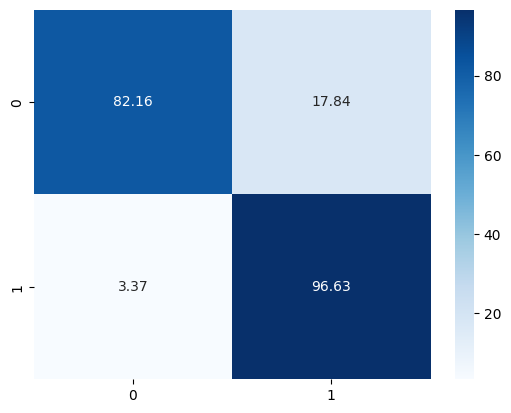

In [11]:
sns.heatmap(confusion_matrix(true_values,predicted_values,normalize='true')*100,annot=True,fmt='.2f',square=False,cmap='Blues')

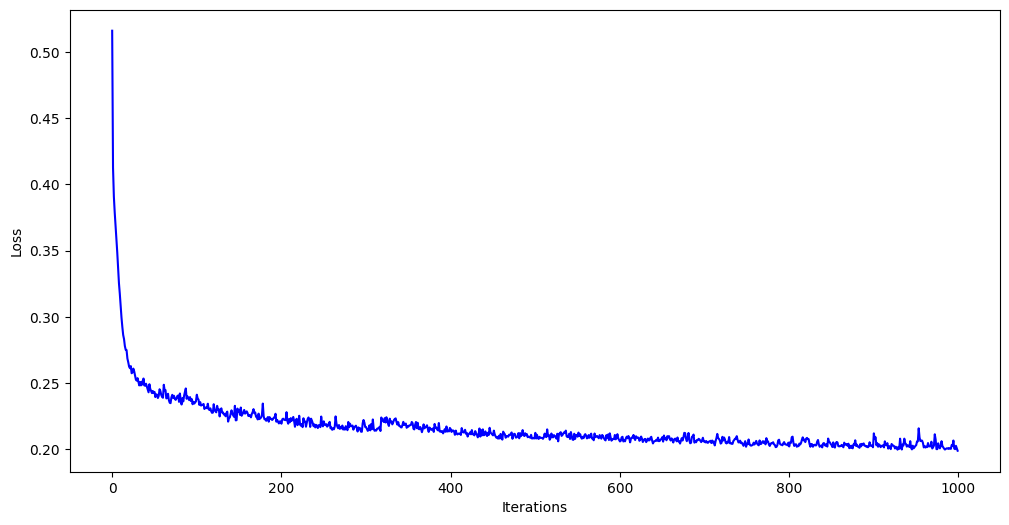

In [12]:
plt.figure(figsize=(12, 6))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(epoch_losses,color='blue')

In [13]:
# del model,x_train_tensor,x_test_tensor,x_eval_tensor,y_train_tensor,y_test_tensor,y_eval_tensor
# torch.cuda.empty_cache()

In [15]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, "checkpoint.pth")

In [ ]:
# checkpoint = torch.load("checkpoint.pth")
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
